# CNN model for Enhancer-Promoter Classification

In this notebook, we will develop a convolutional neural network model to train two enhancer-promoter datasets.

### 1 - Packages
Let's first import all the packages that we will need for this notebook.

- numpy is the fundamental package for scientific computing with Python.
- tensorflow is a high-level framework in Python, and keras is an even higher-level framework and provides additional absstractions 
- matplotlib is a library to plot graphs in Python.
- sklearn is a library that helps us split the dataset and evaluate the model effectively.

In [6]:
import numpy as np
import tensorflow.keras as ks
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc

from util import fasta_data_loader, create_fasta_files_from_csv

### 2 - Load enhancer-promoter dataset

In [7]:
# train, test = fasta_data_loader(pro_fa='data/US_UU/K562_US.fa', enh_fa='data/US_UU/K562_UU.fa')

# train, test = fasta_data_loader(pro_fa='data/CAGE/fantom_promoters_600.fa',
#                                 enh_fa='data/CAGE/fantom_enhancers_600.fa')

CELL_LINE = 'GM12878'

create_fasta_files_from_csv(CELL_LINE)

train, test = fasta_data_loader(pro_fa='data/{}/enhancers.fa'.format(CELL_LINE),
                                enh_fa='data/{}/promoters.fa'.format(CELL_LINE))

# Reshape the data to (n_samples, n_seqs, n_channels)
X_train,Y_train = train[0].transpose([0,2,1]),train[1]
X_test,Y_test = test[0].transpose([0,2,1]),test[1]

Check the training data and testing data

In [8]:
print("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 5740
number of test examples = 638
X_train shape: (5740, 200, 4)
Y_train shape: (5740, 1)
X_test shape: (638, 200, 4)
Y_test shape: (638, 1)


### 3 - The structure of the model

In [9]:
def cnn_model(params):
    
    model = ks.Sequential()
    
    model.add(ks.layers.Conv1D(
                input_shape = (X_train.shape[1], X_train.shape[2]),
                filters = 90,
                kernel_size = params['f1_size'],
                padding = 'same',
                activation = ks.activations.relu))
    
    model.add(ks.layers.Dropout(0.5, input_shape = (X_train.shape[1], 30)))
    model.add(ks.layers.MaxPool1D(
                pool_size = 10,
                strides= 10))

    model.add(ks.layers.Conv1D(
                filters = 128,
                kernel_size= 5,
                padding= 'same',
                activation= ks.activations.relu))

    model.add(ks.layers.Dropout(0.5, input_shape = (X_train.shape[1], 128)))

    model.add(ks.layers.MaxPool1D(
                pool_size= 10,
                strides= 10))

    model.add(ks.layers.Flatten())

    model.add(ks.layers.Dense(
                units= 512,
                activation=ks.activations.relu))

    model.add(ks.layers.Dropout(0.5, input_shape = (512,)))
    
    model.add(ks.layers.Dense(
                units= 1,
                activation=ks.activations.sigmoid,
                name = 'visualized_layer'))

    model.compile(
                optimizer=ks.optimizers.Adam(learning_rate= 0.0003,decay=1e-6),
                loss = ks.losses.BinaryCrossentropy(),
                metrics= [ks.metrics.AUC()])
    
    return model


Test the model structure

In [10]:
params = {'f1_size': 10}
test_model = cnn_model(params)
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 90)           3690      
_________________________________________________________________
dropout (Dropout)            (None, 200, 90)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 90)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           57728     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

### 4 - Model evaluation

In [7]:
def cross_validation(params):
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    total_auc = []
    model = cnn_model(params)
    
    for train, test in kfold.split(X_train, Y_train):      
        history = model.fit(x=X_train[train],
                            y=Y_train[train],
                            validation_data = (X_train[test], Y_train[test]),
                            batch_size= 30,
                            epochs=40,
                            verbose=0)
        
        for key in history.history.keys():
            if key.startswith('auc_'):
                train_auc = history.history[key][-1]
            if key.startswith('val_auc_'):
                valid_auc = history.history[key][-1]
        
        test_loss, test_auc = model.evaluate(X_test, Y_test, verbose = 0)
        mean_auc = (train_auc + valid_auc + test_auc)/3
        total_auc.append(mean_auc)
    
    return model, total_auc


To check whether the filter size in the first layer influences the results.

In [ ]:
filter_size = [9, 19, 29]

file = open('results/n_filters_USUU.txt', 'w')
file.write('f1_size' + ',' + 'mean_aucs' + 'std_aucs' + '\n')

for f1_size in filter_size:
    param_filters = {'f1_size': f1_size}
    model, auc = cross_validation(param_filters)
    mean_aucs = np.mean(auc)
    std_aucs = np.std(auc)
    print(str(f1_size) + ',' + str(mean_aucs) +','+ str(std_aucs))
    file.write(str(f1_size) + ',' + str(mean_aucs) + ',' + str(std_aucs) + '\n')

file.close()
print('finish!')

All these models share similar performances

In [77]:
def best_model():
    
    params = {'f1_size': 19}
    model = cnn_model(params)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    
    i = 0
    tprs = []
    auc_total = []
    tprs_pred_total = []
    tprs_test_total = []

    mean_fpr = np.linspace(0, 1, 100)
    
    for train, test in kfold.split(X_train, Y_train):      
        model.fit(
                x=X_train[train],
                y=Y_train[train],
                batch_size= 30,
                epochs= 40,
                verbose=0)
        
        y_pred = model.predict(X_train[test]).ravel()
        fpr_pred, tpr_pred, _ = roc_curve(Y_train[test], y_pred)
        tprs_pred = np.interp(mean_fpr, fpr_pred, tpr_pred)
        tprs_pred[0] = 0.0
        tprs_pred_total.append(tprs_pred)
        
        y_test_pred = model.predict(X_test).ravel()
        test_fpr,test_tpr, _ = roc_curve(Y_test, y_test_pred)
        tprs_test = np.interp(mean_fpr, test_fpr, test_tpr)
        tprs_test[0] = 0.0
        tprs_test_total.append(tprs_test)
        
        mean_tprs = (tprs_pred + tprs_test)/2
        tprs.append(mean_tprs)
#        mean_auc = auc(mean_fpr, mean_tprs)
#        auc_total.append(mean_auc)
#        print(mean_auc)
    
    tprs_pred_mean = np.mean(tprs_pred_total, axis = 0)
    tprs_test_mean = np.mean(tprs_test_total, axis = 0)
    
    tprs.append(tprs_pred_mean)
    tprs.append(tprs_test_mean)
    
    return model, tprs 
        

In [78]:
def plot_roc_curve(tprs):
    
    mean_tprs, mean_pred_tprs, mean_test_tprs = tprs[0:4], tprs[5], tprs[6]
    mean_fpr = np.linspace(0, 1, 100)
    
    mean_tpr = np.mean(mean_tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr,mean_tpr)
    mean_pred_auc = auc(mean_fpr, mean_pred_tprs)
    mean_test_auc = auc(mean_fpr, mean_test_tprs)
    
    plt.figure(1)
    plt.plot([-0.05, 1], [-0.05, 1], 'k--')
    plt.plot(mean_fpr,mean_tpr,color='b',label='Mean ROC (AUC=%0.2f)' % mean_auc,lw=2,alpha=.8)
    plt.plot(mean_fpr,mean_pred_tprs,color='r',label='Mean Train ROC (AUC=%0.2f)' % mean_pred_auc,lw=2,alpha=.8)
    plt.plot(mean_fpr,mean_test_tprs,color='y',label='Mean Test ROC (AUC=%0.2f)' % mean_test_auc,lw=2,alpha=.8)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of CNN-10(90) CAGE model')
    plt.legend(loc='lower right')
    plt.savefig('results/CAGE_roc.png')
    plt.show()

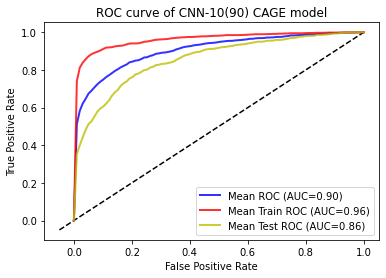

In [79]:
cnn_model, tprs = best_model()
plot_roc_curve(tprs)